In [1]:
import json
import pandas as pd
import plotly.graph_objects as go
from plotly.offline import iplot

In [2]:
def read_webrtc_stats_json(file):
    with open(file) as f:
        for line in f:
            yield json.loads(line)

In [3]:
stats_types = [
    "codec",
    "inbound-rtp",
    "outbound-rtp",
    "remote-inbound-rtp",
    "remote-outbound-rtp",
    "media-source",
    "media-playout",
    "peer-connection",
    "data-channel",
    "transport",
    "candidate-pair",
    "local-candidate",
    "remote-candidate",
    "certificate"
]

In [4]:
media_c0_stats = [x for x in read_webrtc_stats_json('../webrtc/media/get_stats_client_0.json')]
media_c1_stats = [x for x in read_webrtc_stats_json('../webrtc/media/get_stats_client_1.json')]
media_x_data_c0_stats = [x for x in read_webrtc_stats_json('../webrtc/media_x_data/get_stats_client_0.json')]
media_x_data_c1_stats = [x for x in read_webrtc_stats_json('../webrtc/media_x_data/get_stats_client_1.json')]

media_c0_dfs = {t: pd.DataFrame([x for xs in media_c0_stats for x in xs if x['type'] == t]) for t in stats_types}
media_c1_dfs = {t: pd.DataFrame([x for xs in media_c1_stats for x in xs if x['type'] == t]) for t in stats_types}
media_x_data_c0_dfs = {t: pd.DataFrame([x for xs in media_x_data_c0_stats for x in xs if x['type'] == t]) for t in stats_types}
media_x_data_c1_dfs = {t: pd.DataFrame([x for xs in media_x_data_c1_stats for x in xs if x['type'] == t]) for t in stats_types}

for d in [media_c0_dfs, media_c1_dfs, media_x_data_c0_dfs, media_x_data_c1_dfs]:
    for k, df in d.items():
        if 'timestamp' in df.columns:
            df['ts'] = pd.to_datetime(df['timestamp'], unit = 'ms')
            df.set_index('ts', inplace=True)

In [16]:
def plot(data, dc=False):
    target = data['outbound-rtp'][data['outbound-rtp']['kind']=='video']['targetBitrate']
    rate = data['outbound-rtp'][data['outbound-rtp']['kind']=='video']['bytesSent'].diff().apply(lambda x: x * 8).resample('1s').sum()
    transport_rate = data['transport']['bytesSent'].diff().apply(lambda x: x * 8).resample('1s').sum()
    
    fig = go.Figure()

    if dc:
        dc_rate = data['data-channel'][media_x_data_c0_dfs['data-channel']['id']=='D1']['bytesSent'].diff().apply(lambda x: x * 8).resample('1s').sum()
        fig.add_trace(go.Scatter(x=dc_rate.index, y=dc_rate, name='dc_rate', mode='lines'))
    
    fig.add_trace(go.Scatter(x=target.index, y=target, name='targetrate', mode='lines'))
    fig.add_trace(go.Scatter(x=rate.index, y=rate, name='sentrate', mode='lines'))
    fig.add_trace(go.Scatter(x=transport_rate.index, y=transport_rate, name='transport_rate', mode='lines'))
    fig.show()

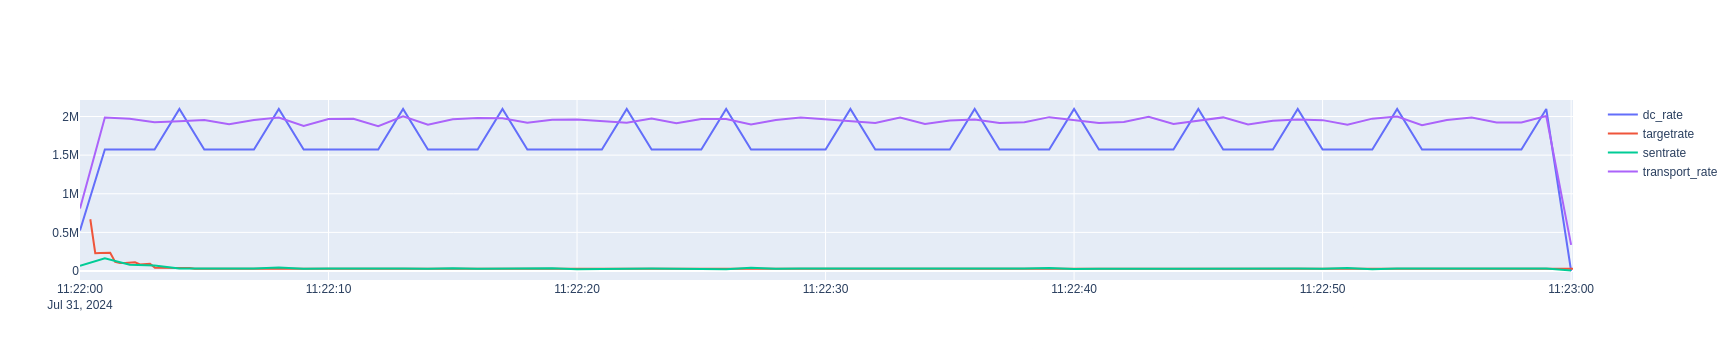

In [17]:
plot(media_x_data_c0_dfs, True)

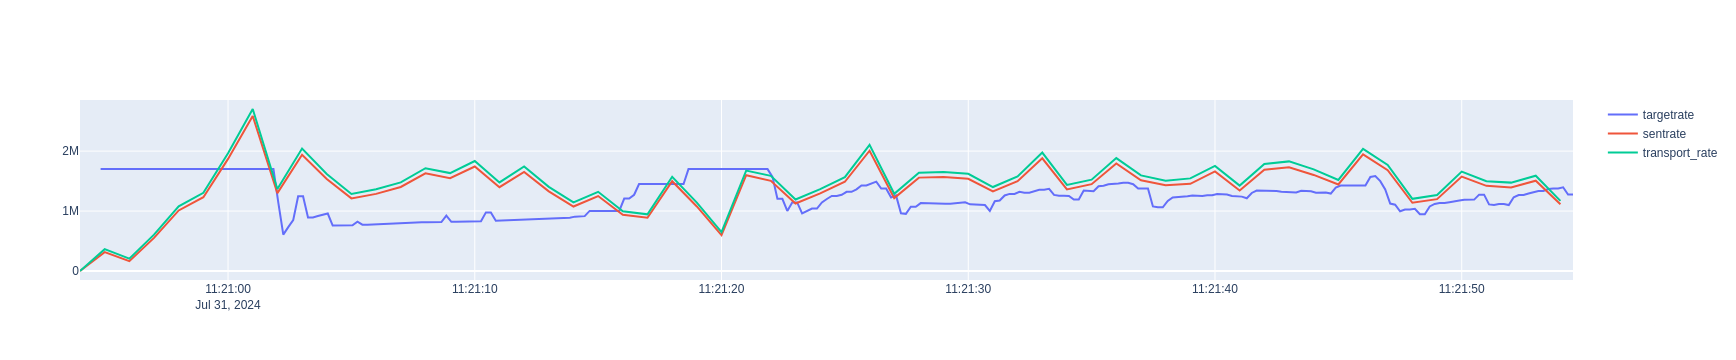

In [18]:
plot(media_c0_dfs)

In [11]:
dc_rate = media_x_data_c0_dfs['data-channel'][media_x_data_c0_dfs['data-channel']['id']=='D1']['bytesSent'].diff().apply(lambda x: x * 8).resample('1s').sum()
dc_rate

ts
2024-07-31 11:22:00     524280.0
2024-07-31 11:22:01    1572840.0
2024-07-31 11:22:02    1572840.0
2024-07-31 11:22:03    1572840.0
2024-07-31 11:22:04    2097120.0
                         ...    
2024-07-31 11:22:56    1572840.0
2024-07-31 11:22:57    1572840.0
2024-07-31 11:22:58    1572840.0
2024-07-31 11:22:59    2097120.0
2024-07-31 11:23:00          0.0
Freq: s, Name: bytesSent, Length: 61, dtype: float64